## Problem:

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.


### Steps:

a) Understanding Data:

1) Hypothesis Generation

2) Getting the system ready and loading the data

3) Dataset Structure and Content

4) Feature Extraction

5) Exploratory Analysis

b) Forecasting using Multiple Modeling Techniques:

1) Splitting the data into training and validation part

2) Modeling techniques

3) Holt’s Linear Trend Model on daily time series

4) Holt Winter’s Model on daily time series

5) Introduction to ARIMA model

6) Parameter tuning for ARIMA model

7) SARIMAX model on daily time series

In [105]:




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings    # To ignore the warnings warnings.filterwarnings("ignore")


### a) Understanding Data:

#### 1) Hypothesis Generation

- Hypothesis generation helps us to point out the factors which might affect our dependent variable. Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail:

- There will be an increase in the traffic as the years pass by.

Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, - -generally companies expand their businesses over time leading to more customers travelling through JetRail.
- The traffic will be high from May to October.

Explanation - Tourist visits generally increases during this time perion.
- Traffic on weekdays will be more as compared to weekends/holidays.

Explanation - People will go to office on weekdays and hence the traffic will be more
- Traffic during the peak hours will be high.

Explanation - People will travel to work, college.


#### 2) Getting the system ready and loading the data

In [106]:
train_original=pd.read_csv("C:/Subhajit/Newfolder/IOT/DS/Machine Learining/Time Series Forecast/Train_SU63ISt.csv")
test_original=pd.read_csv("C:/Subhajit/Newfolder/IOT/DS/Machine Learining/Time Series Forecast/Test_0qrQsBZ.csv")
train=train_original.copy()
test=test_original.copy()

In [107]:
train_original.head()

ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2

In [108]:
test_original.head()

ID          Datetime
0  18288  26-09-2014 00:00
1  18289  26-09-2014 01:00
2  18290  26-09-2014 02:00
3  18291  26-09-2014 03:00
4  18292  26-09-2014 04:00

#### 3) Dataset Structure and Content

In [109]:
train.columns
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [110]:
test.columns
test.dtypes

ID           int64
Datetime    object
dtype: object

#### 4)  Feature Extraction

- We will extract the time and date from the Datetime. We have seen earlier that the data type of Datetime is object. So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [111]:
#Converting the date into date and time format
train['Datetime']=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime']=pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')

train_original['Datetime']=pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')
test_original['Datetime']=pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')

In [112]:
train.head()

ID            Datetime  Count
0   0 2012-08-25 00:00:00      8
1   1 2012-08-25 01:00:00      2
2   2 2012-08-25 02:00:00      6
3   3 2012-08-25 03:00:00      2
4   4 2012-08-25 04:00:00      2

- We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [113]:
#Feature Extracton
for i in (train,test,train_original,test_original):
    i['year']=i.Datetime.dt.year
    i['month']=i.Datetime.dt.month
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour

- We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.

We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.

Values of 5 and 6 represents that the days are weekend.

In [114]:
train.head()

ID            Datetime  Count  year  month  day  Hour
0   0 2012-08-25 00:00:00      8  2012      8   25     0
1   1 2012-08-25 01:00:00      2  2012      8   25     1
2   2 2012-08-25 02:00:00      6  2012      8   25     2
3   3 2012-08-25 03:00:00      2  2012      8   25     3
4   4 2012-08-25 04:00:00      2  2012      8   25     4

In [115]:
train['day of week']=train['Datetime'].dt.dayofweek
temp=train['Datetime']

- Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [116]:
def applyer(row):
    if row.dayofweek==5 or row.dayofweek==6:
        return 1
    else:
        return 0
train['weekend']=train.Datetime.apply(applyer)


In [117]:
train.head()

ID            Datetime  Count  year  month  day  Hour  day of week  weekend
0   0 2012-08-25 00:00:00      8  2012      8   25     0            5        1
1   1 2012-08-25 01:00:00      2  2012      8   25     1            5        1
2   2 2012-08-25 02:00:00      6  2012      8   25     2            5        1
3   3 2012-08-25 03:00:00      2  2012      8   25     3            5        1
4   4 2012-08-25 04:00:00      2  2012      8   25     4            5        1

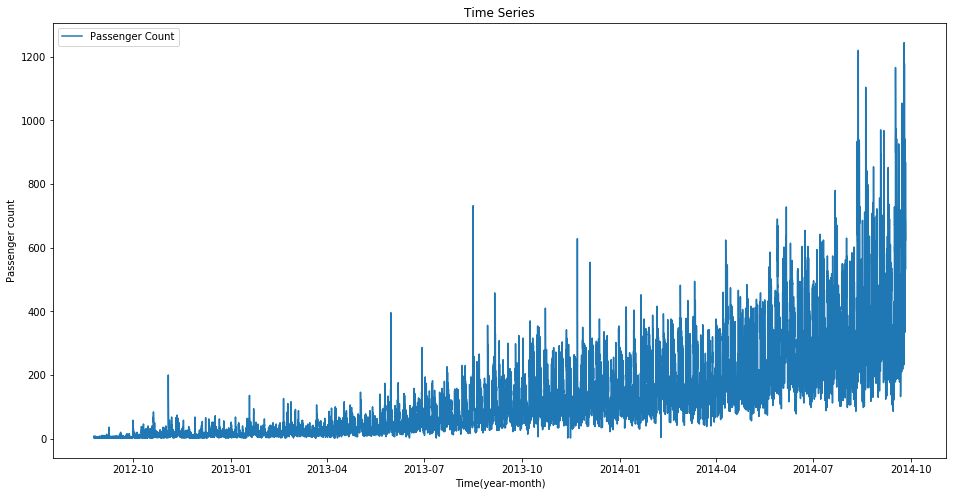

In [118]:
#Lets look at the time series
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

- Here we can infer that there is an increasing trend in the series, i.e., the number of count is increasing with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.

We will work on the train file for all the analysis and will use the test file for forecasting.

Lets recall the hypothesis that we made earlier:

- Traffic will increase as the years pass by
- Traffic will be high from May to October
- Traffic on weekdays will be more
- Traffic during the peak hours will be high

After having a look at the dataset, we will now try to validate our hypothesis and make other inferences from the dataset.

### 5) Exploratory Analysis

Let us try to verify our hypothesis using the actual data.

Our first hypothesis was traffic will increase as the years pass by. So let’s look at yearly passenger count.

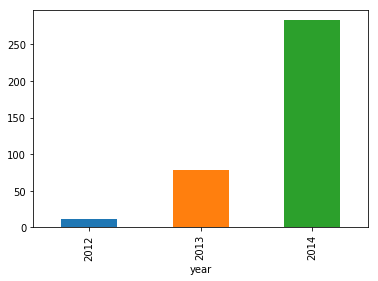

In [119]:
train.groupby('year')['Count'].mean().plot.bar()

- We see an exponential growth in the traffic with respect to year which validates our hypothesis.

- Our second hypothesis was about increase in traffic from May to October. So, let’s see the relation between count and month.

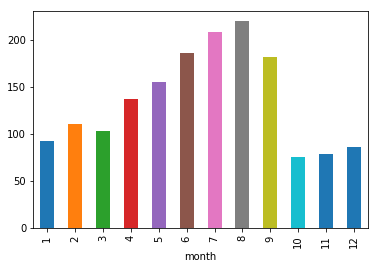

In [120]:
train.groupby('month')['Count'].mean().plot.bar()

- Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately.

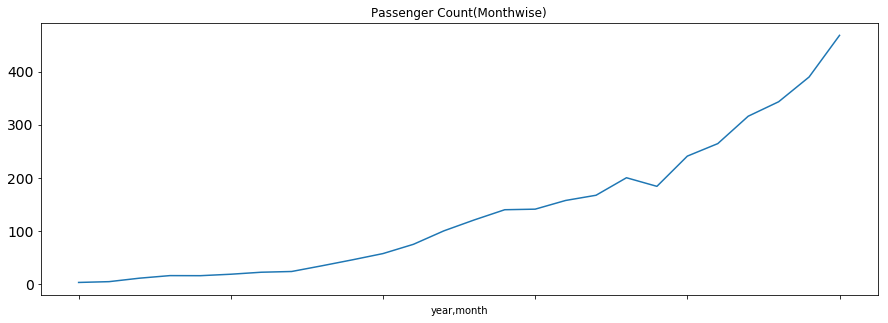

In [121]:
temp=train.groupby(['year','month'])['Count'].mean()
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

- We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.
- Since there is an increasing trend in our time series, the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.

- In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

### Let’s look at the daily mean of passenger count.

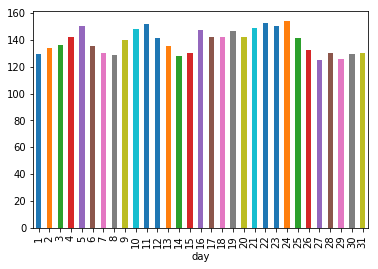

In [122]:
train.groupby('day')['Count'].mean().plot.bar()

- We are not getting much insights from day wise count of the passengers.

- We also made a hypothesis that the traffic will be more during peak hours. So let’s see the mean of hourly passenger count.

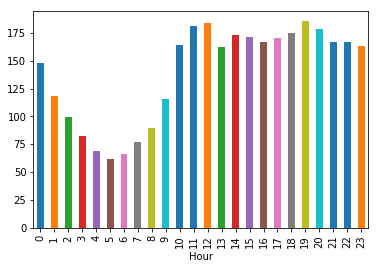

In [123]:
train.groupby('Hour')['Count'].mean().plot.bar()

- It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
- After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

#### Let’s try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.

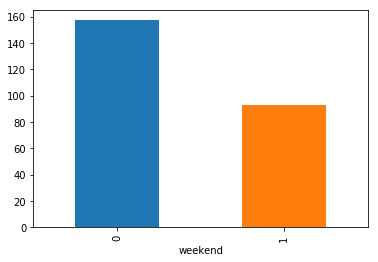

In [124]:
train.groupby('weekend')['Count'].mean().plot.bar()

- It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.

#### Now we will try to look at the day wise passenger count.

Note - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

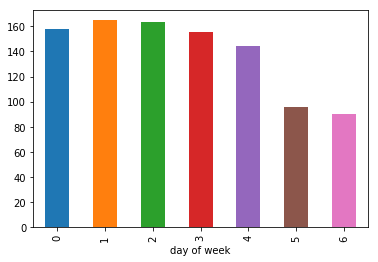

In [125]:
train.groupby('day of week')['Count'].mean().plot.bar()

- From the above bar plot, we can infer that the passenger count is less for saturday and sunday as compared to the other days of the week. Now we will look at basic modeling techniques. Before that we will drop the ID variable as it has nothing to do with the passenger count.

In [126]:
train=train.drop('ID',1)

- As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [127]:
train.Timestamp=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index=train.Timestamp
# Hourly time series
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


- Let’s look at the hourly, daily, weekly and monthly time series.

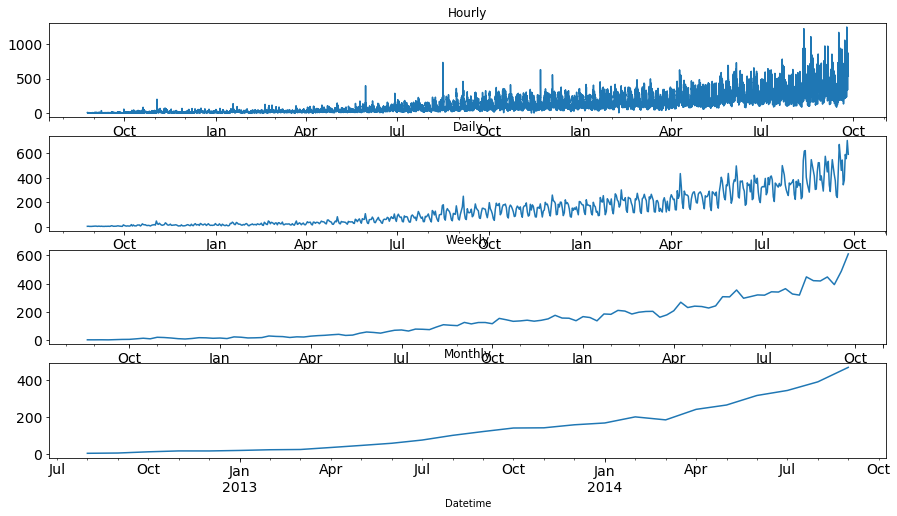

In [128]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

- We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

- But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

### b) Forecasting using Multiple Modeling Techniques:

#### 1) Splitting the data into training and validation part

In [129]:
test.Timestamp=pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test.index = test.Timestamp 
# Converting to daily mean 
test = test.resample('D').mean() 

C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [130]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()

- It is always a good practice to create a validation set that can be used to assess our models locally. If the validation metric(rmse) is changing in proportion to public leaderboard score, this would imply that we have chosen a stable validation technique.


- To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

In [131]:
Train=train.ix['2012-08-25':'2014-06-24']
valid=train.ix['2014-06-25':'2014-09-25']

C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


- We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

- Lets understand it in this way: If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.

#### Now we will look at how the train and validation part has been divided.

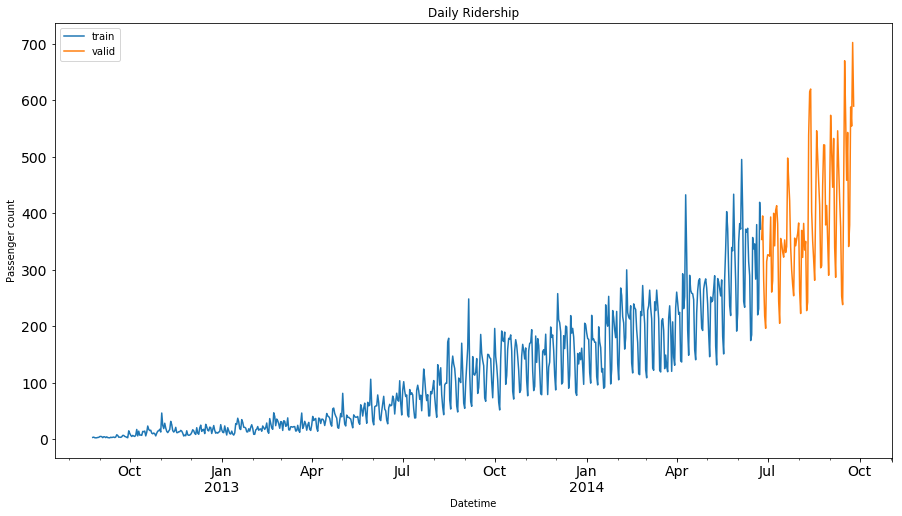

In [132]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

### 2) Modeling techniques

## Methods which we will be discussing for the forecasting

i) Naive Approach
ii) Moving Average
iii) Simple Exponential Smoothing
iv) Holt’s Linear Trend Model

### i) Naive Approach

#### Let’s make predictions using naive approach for the validation set.

- In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction.

In [133]:
dd= np.asarray(Train.Count) 
dd

array([  3.16666667,   3.66666667,   2.58333333,   2.41666667,
         2.5       ,   3.08333333,   3.25      ,   4.66666667,
         4.91666667,   4.5       ,   2.75      ,   4.33333333,
         4.16666667,   2.83333333,   4.16666667,   2.83333333,
         2.66666667,   2.41666667,   3.5       ,   3.        ,
         3.5       ,   3.83333333,   2.91666667,   3.83333333,
         7.83333333,   6.58333333,   3.5       ,   3.75      ,
         3.25      ,   4.25      ,   6.75      ,   6.66666667,
         4.91666667,   4.33333333,   3.25      ,   2.58333333,
        14.83333333,  10.33333333,   6.91666667,   4.83333333,
         6.66666667,   5.58333333,   4.91666667,   7.        ,
        17.25      ,   5.83333333,  14.25      ,   7.16666667,
         7.41666667,   6.83333333,  13.75      ,  13.41666667,
        14.41666667,   5.83333333,  12.16666667,  23.33333333,
        17.33333333,  15.33333333,  15.91666667,  10.66666667,
         9.58333333,  10.91666667,   9.66666667,   5.83

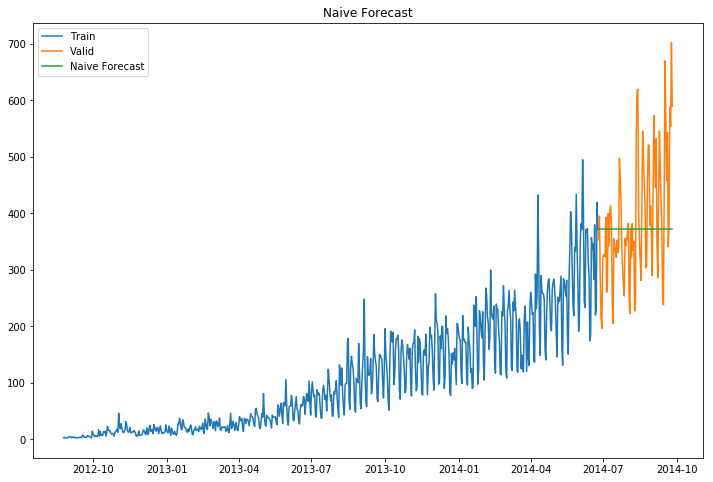

In [134]:
dd= np.asarray(Train.Count) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()
#plt.yticks(list(dict.values()))

- We can calculate how accurate our predictions are using rmse(Root Mean Square Error).
- rmse is the standard deviation of the residuals.
 - Residuals are a measure of how far from the regression line data points are.

#### We will now calculate RMSE to check the accuracy of our model on validation data set.

RMSE formula:  rmse=sqrt∑i=1N1N(p−a)2

In [135]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

111.79050467496724


- We can infer that this method is not suitable for datasets with high variability. We can reduce the rmse value by adopting different techniques.

### ii) Moving Average
 - In this technique we will take the average of the passenger counts for last few time periods only.
 
 - Here the predictions are made on the basis of the average of last few points instead of taking all the previously known values.

- Lets try the rolling mean for last 10, 20, 50 days and visualize the results.

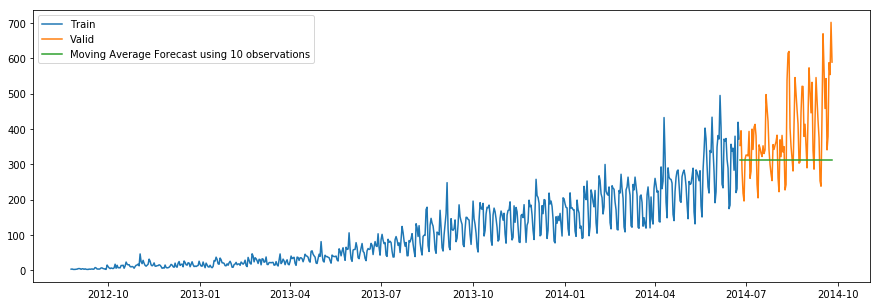

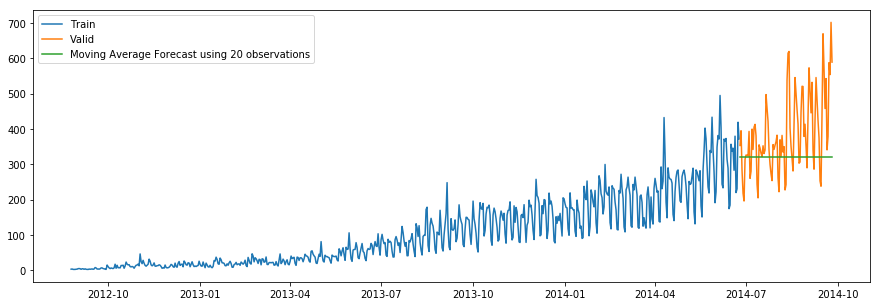

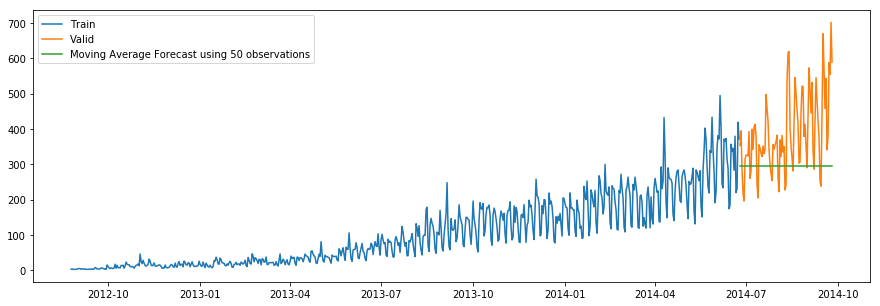

In [136]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

- We took the average of last 10, 20 and 50 observations and predicted based on that. This value can be changed in the above code in .rolling().mean() part. We can see that the predictions are getting weaker as we increase the number of observations.

- using RMSE

In [137]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

144.19175679986802


- here, the RMSE is again high.

### iii) Simple Exponential Smoothing

- In this technique, we assign larger weights to more recent observations than to observations from the distant past.
- The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

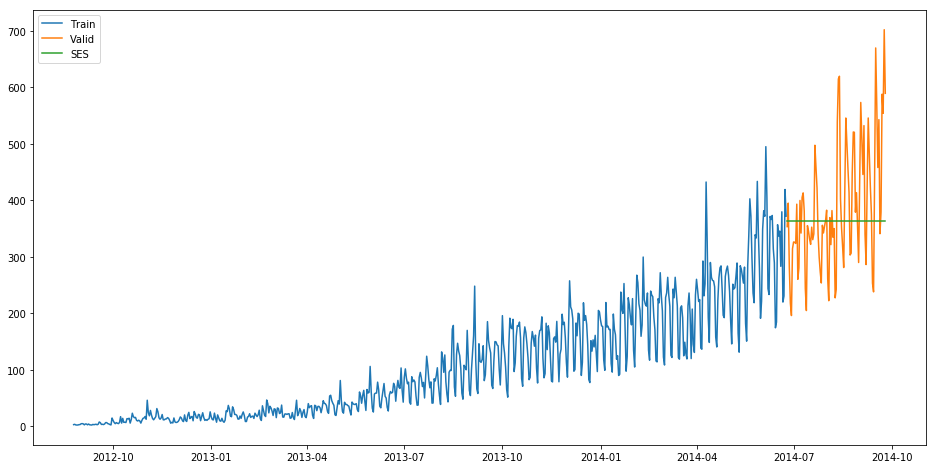

In [138]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

- Calculate the RMSE

In [139]:
rms=sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

113.43708111884514


- We can infer that the fit of the model has improved as the rmse value has reduced.

### iv) Holt’s Linear Trend Model

- It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
- This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.
- First of all let us visualize the trend, seasonality and error in the series.

##### We can decompose the time series in four parts.

- Observed, which is the original time series.
- Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
- Seasonal, which tells us about the seasonality in the time series.
- Residual, which is obtained by removing any trend or seasonality in the time series.



- Lets visualize all these parts.

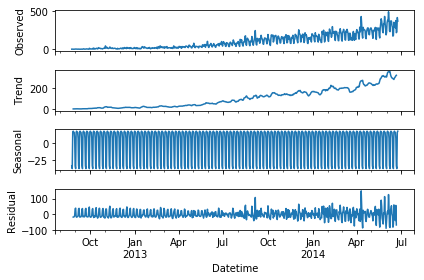

In [140]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count) 
plt.show()

- An increasing trend can be seen in the dataset, so now we will make a model based on the trend.

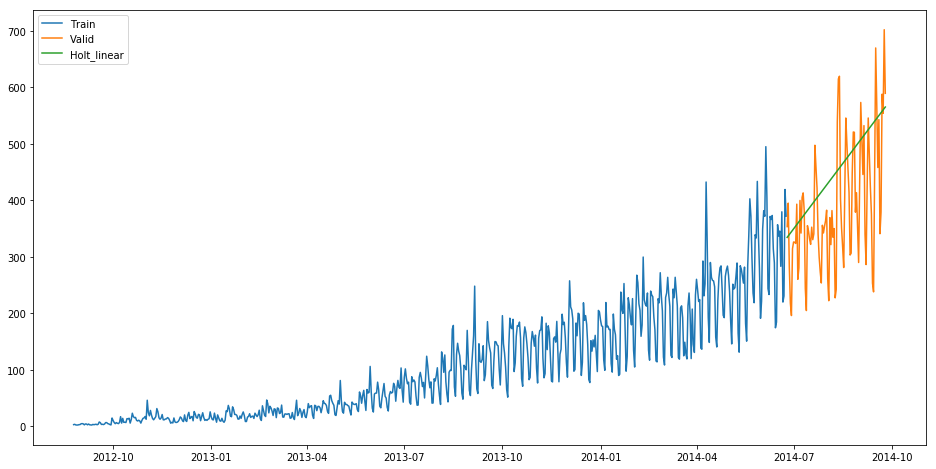

In [214]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [215]:
valid.head()

Count    year  month   day  Hour  day of week  weekend
Datetime                                                               
2014-06-25  353.666667  2014.0    6.0  25.0  11.5          2.0      0.0
2014-06-26  395.250000  2014.0    6.0  26.0  11.5          3.0      0.0
2014-06-27  282.333333  2014.0    6.0  27.0  11.5          4.0      0.0
2014-06-28  218.250000  2014.0    6.0  28.0  11.5          5.0      1.0
2014-06-29  196.250000  2014.0    6.0  29.0  11.5          6.0      1.0

In [216]:
y_hat_avg.head()

Count    year  month   day  Hour  day of week  weekend  \
Datetime                                                                  
2014-06-25  353.666667  2014.0    6.0  25.0  11.5          2.0      0.0   
2014-06-26  395.250000  2014.0    6.0  26.0  11.5          3.0      0.0   
2014-06-27  282.333333  2014.0    6.0  27.0  11.5          4.0      0.0   
2014-06-28  218.250000  2014.0    6.0  28.0  11.5          5.0      1.0   
2014-06-29  196.250000  2014.0    6.0  29.0  11.5          6.0      1.0   

            Holt_linear  
Datetime                 
2014-06-25   334.650767  
2014-06-26   337.159011  
2014-06-27   339.667256  
2014-06-28   342.175500  
2014-06-29   344.683745

- We can see an inclined line here as the model has taken into consideration the trend of the time series.

In [142]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

112.94278345314041


- It can be inferred that the rmse value has decreased.

- Now we will be predicting the passenger count for the test dataset using various models.

## 3) Holt’s Linear Trend Model on daily time series

- Now let’s try to make holt’s linear trend model on the daily time series and make predictions on the test dataset.
- We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.
- We have fitted the holt’s linear trend model on the train dataset and validated it using validation dataset.

In [143]:
submission=pd.read_csv("C:/Subhajit/Newfolder/IOT/DS/Machine Learining/Time Series Forecast/Sample_Submission_QChS6c3.csv")

- We only need ID and corresponding Count for the final submission.

- Let’s make prediction for the test dataset.

In [144]:
predict=fit1.forecast(len(test))

- Let’s save these predictions in test file in a new column.

In [145]:
test['prediction']=predict

- Remember this is the daily predictions. We have to convert these predictions to hourly basis. * To do so we will first calculate the ratio of passenger count for each hour of every day. * Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. * Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [146]:
test.head()

ID    year  month   day  Hour  prediction
Datetime                                                  
2014-09-26  18299.5  2014.0    9.0  26.0  11.5  334.650767
2014-09-27  18323.5  2014.0    9.0  27.0  11.5  337.159011
2014-09-28  18347.5  2014.0    9.0  28.0  11.5  339.667256
2014-09-29  18371.5  2014.0    9.0  29.0  11.5  342.175500
2014-09-30  18395.5  2014.0    9.0  30.0  11.5  344.683745

In [147]:
# Calculating the hourly ratio of count 
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 
temp=train_original.groupby(['Hour'])['ratio'].sum()

In [148]:
# Groupby to csv format 
pd.DataFrame(temp,columns=['Hour','ratio']).to_csv('GROUPby.csv')

In [149]:
temp2=pd.read_csv('GROUPby.csv')
temp2=temp2.drop('Hour.1',1)

In [150]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 

In [151]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 


In [152]:
# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24 
prediction['ID']=prediction['ID_y']

- Let’s drop all other features from the submission file and keep ID and Count only.

In [153]:
submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','Hour', 'ratio'],axis=1) 

In [154]:
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

In [155]:
# calculating rmse score
rms=sqrt(mean_squared_error(prediction.Count, prediction.prediction)) 
print(rms)

191.1468750000765


- Now let’s look at how well the Holt winters model predict the passenger counts for test dataset.

## 4) Holt winter’s model on daily time series

- Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

- The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

- One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.


#### Let’s first fit the model on training dataset and validate it using the validation dataset.

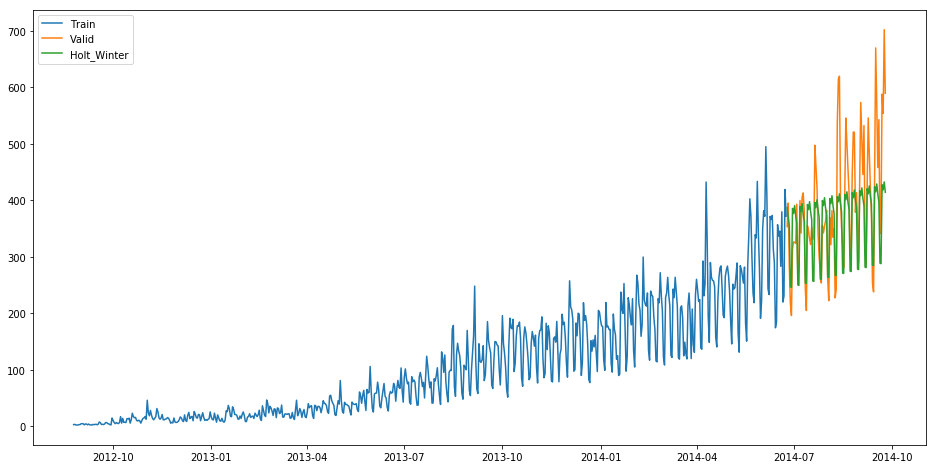

In [156]:
y_hat_avg=valid.copy()


fit1=ExponentialSmoothing(np.asarray(Train['Count']),seasonal_periods=7,trend='add',seasonal='add').fit()
y_hat_avg['Holt_Winter']=fit1.forecast(len(valid))  
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best') 
plt.show()

In [157]:
# calculating rmse score
rms=sqrt(mean_squared_error(valid.Count, y_hat_avg['Holt_Winter'])) 
print(rms)

82.37467736825413


- We can see that the rmse value has reduced a lot from this method. Let’s forecast the Counts for the entire length of the Test dataset.

In [158]:
predict=fit1.forecast(len(test))
test['prediction']=predict

- Now we will convert these daily passenger count into hourly passenger count using the same approach which we followed above.

In [159]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 


In [160]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left')

In [161]:
# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24

- Let’s drop all features other than ID and Count

In [162]:
prediction['ID']=prediction['ID_y'] 

In [163]:
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

In [164]:
# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv')

In [165]:
rms=sqrt(mean_squared_error(submission.Count, prediction['prediction'])) 
print(rms)

122.02175899304034


- Holt winters model produced rmse of 328.356 on the leaderboard.- 
- The possible reason behind this may be that this model was not that good in predicting the trend of the time series but worked really well on the seasonality part.
- Till now we have made different models for trend and seasonality. Can’t we make a model which will consider both the trend and seasonality of the time series?

#### Yes we can. We will look at the ARIMA model for time series forecasting.

### 6) Parameter tuning for ARIMA model

#### Stationarity Check by Dickey fuller test

- The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
- The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

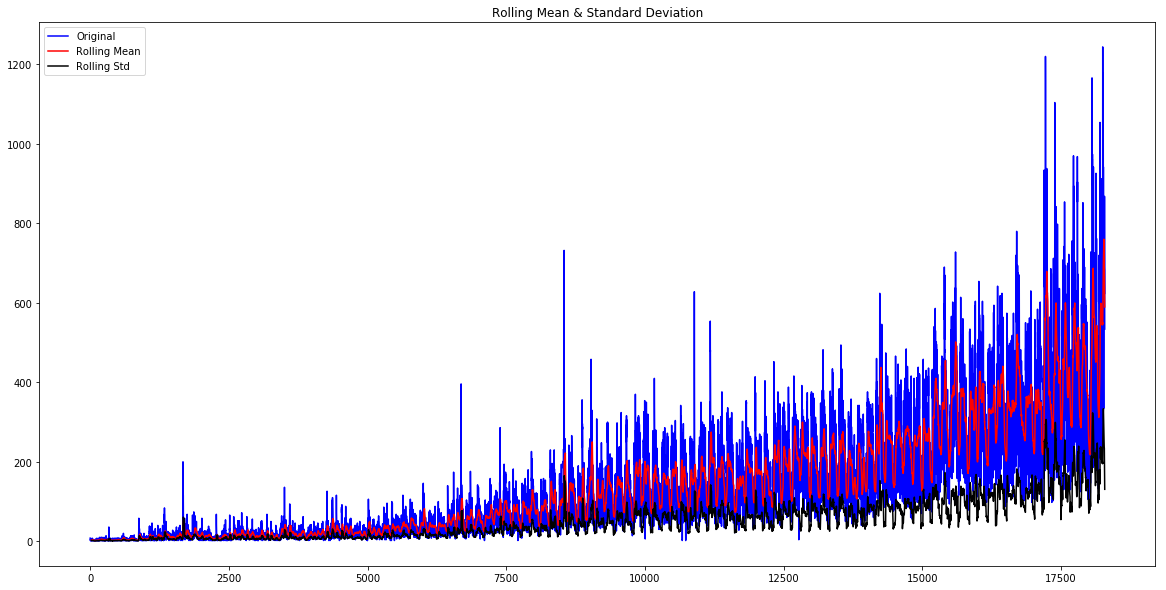

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [166]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])


- The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

### Removing Trend
- We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.


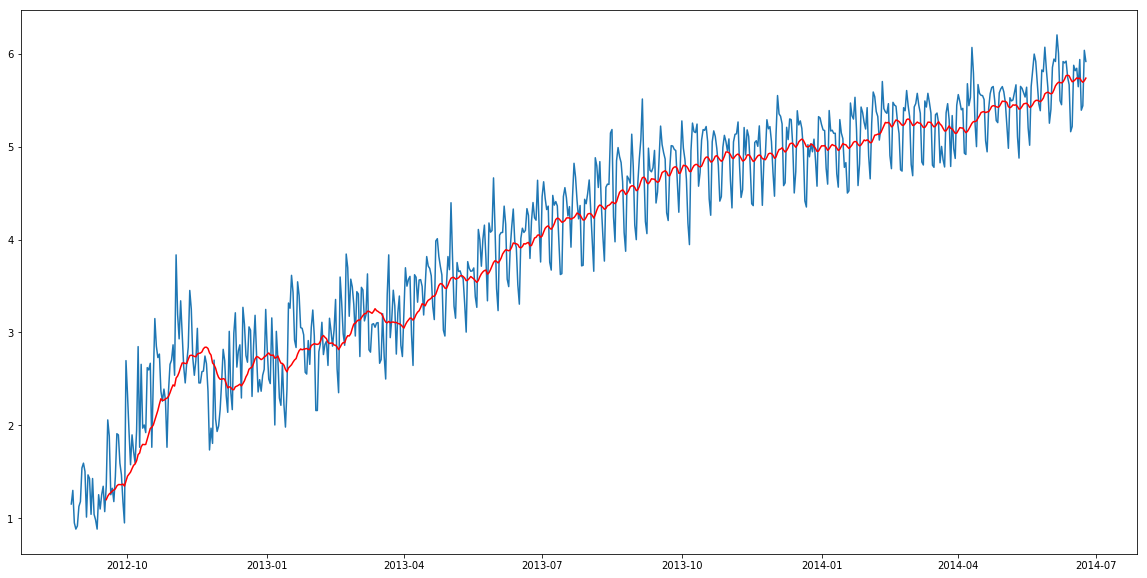

In [229]:
Train_log=np.log(Train['Count'])
valid_log=np.log(valid['Count'])
moving_avg_trend=Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg_trend,color='red')
plt.show()

- So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [230]:
moving_avg_trend_difference=Train_log-moving_avg_trend

In [233]:
Train_log.head(26)

Datetime
2012-08-25    1.152680
2012-08-26    1.299283
2012-08-27    0.949081
2012-08-28    0.882389
2012-08-29    0.916291
2012-08-30    1.126011
2012-08-31    1.178655
2012-09-01    1.540445
2012-09-02    1.592631
2012-09-03    1.504077
2012-09-04    1.011601
2012-09-05    1.466337
2012-09-06    1.427116
2012-09-07    1.041454
2012-09-08    1.427116
2012-09-09    1.041454
2012-09-10    0.980829
2012-09-11    0.882389
2012-09-12    1.252763
2012-09-13    1.098612
2012-09-14    1.252763
2012-09-15    1.343735
2012-09-16    1.070441
2012-09-17    1.343735
2012-09-18    2.058388
2012-09-19    1.884541
Freq: D, Name: Count, dtype: float64

In [234]:
moving_avg_trend_difference.head(26)

Datetime
2012-08-25         NaN
2012-08-26         NaN
2012-08-27         NaN
2012-08-28         NaN
2012-08-29         NaN
2012-08-30         NaN
2012-08-31         NaN
2012-09-01         NaN
2012-09-02         NaN
2012-09-03         NaN
2012-09-04         NaN
2012-09-05         NaN
2012-09-06         NaN
2012-09-07         NaN
2012-09-08         NaN
2012-09-09         NaN
2012-09-10         NaN
2012-09-11         NaN
2012-09-12         NaN
2012-09-13         NaN
2012-09-14         NaN
2012-09-15         NaN
2012-09-16         NaN
2012-09-17    0.144489
2012-09-18    0.821405
2012-09-19    0.623172
Freq: D, Name: Count, dtype: float64

- Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

In [170]:
moving_avg_trend_difference.dropna(inplace=True)

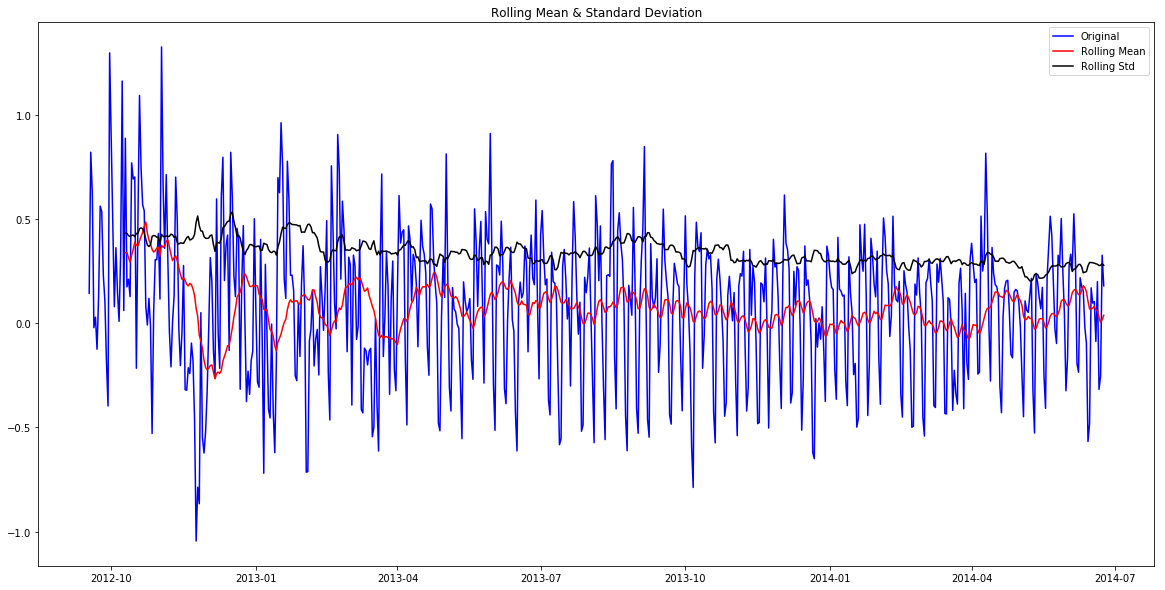

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [171]:
test_stationarity(moving_avg_trend_difference)

- We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.
- Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

- Differencing can help to make the series stable and eliminate the trend.

In [172]:
train_log_diff=Train_log-Train_log.shift(1)

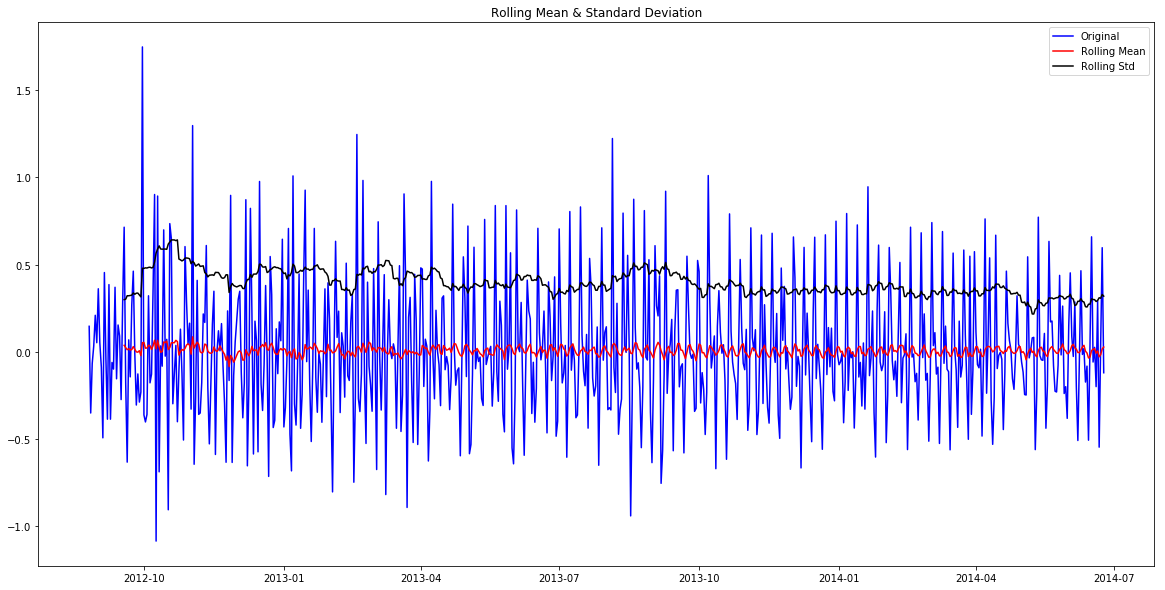

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [173]:
test_stationarity(train_log_diff.dropna())

- Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

### Removing Seasonality
- By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
- We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

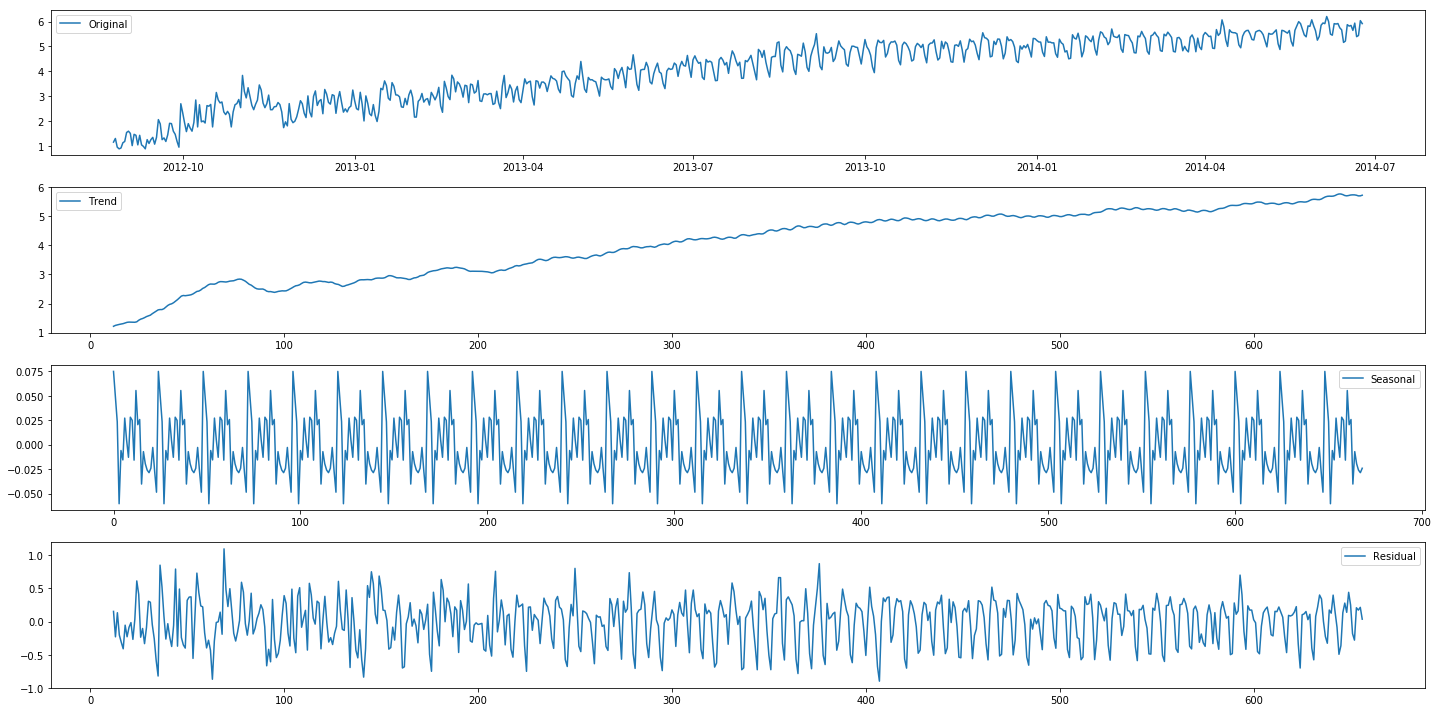

In [219]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 
trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 
plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best') 
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout() 
plt.show()

- We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.
- Let’s check stationarity of residuals.

In [220]:
decomposition

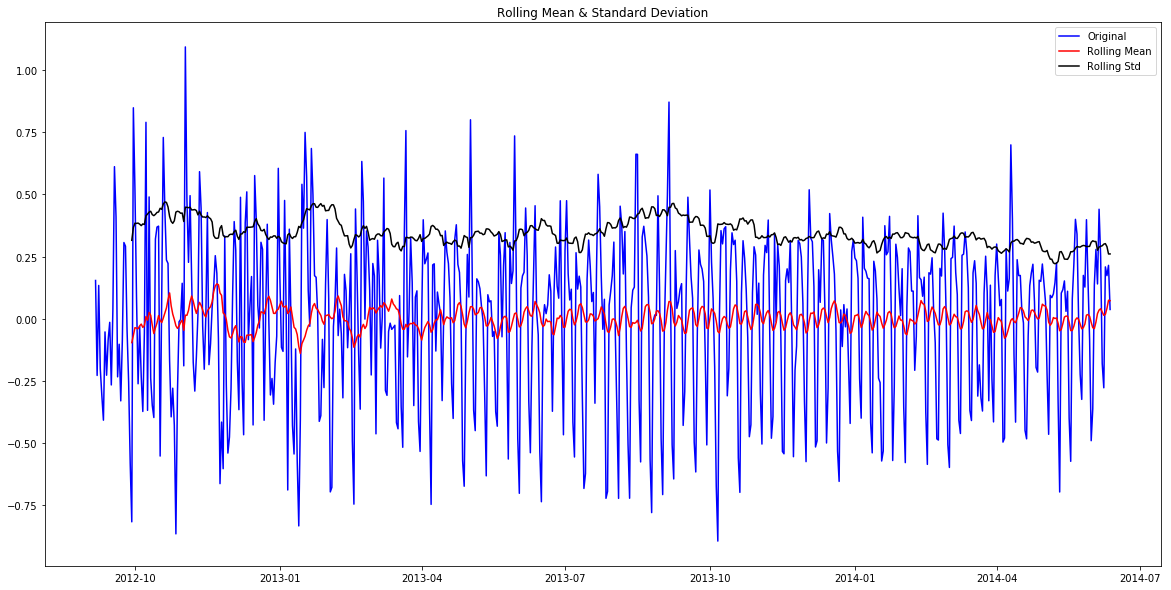

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [175]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

- We removed Trend and Seasonality from the data 
## Forecasting the time series using ARIMA



- First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

- To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

- ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

- PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [176]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

#### ACF plot

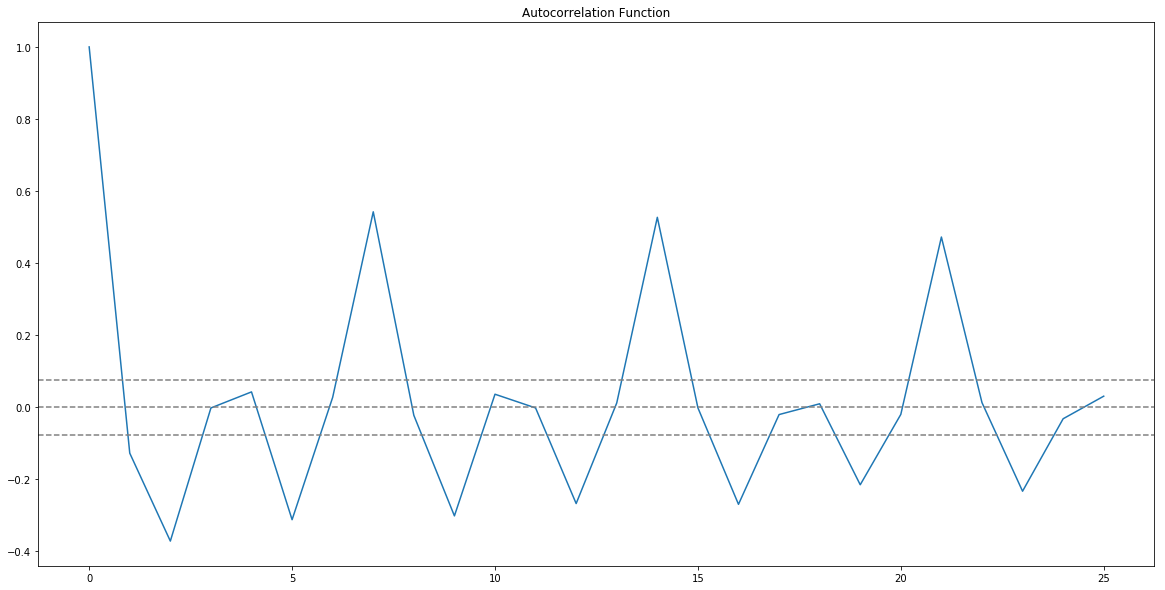

In [177]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

In [182]:
from pandas.tools.plotting import autocorrelation_plot
from matplotlib import pyplot as plt

C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


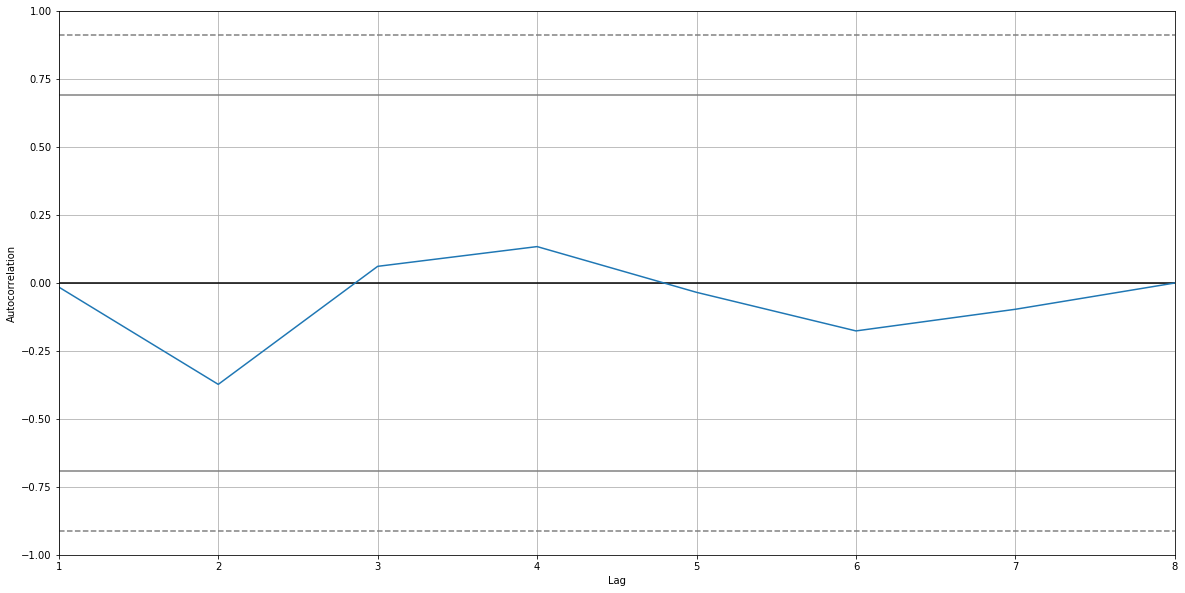

In [184]:
train_Q=train_log_diff.dropna().resample('Q').mean()
autocorrelation_plot(train_Q)
plt.show()

In [185]:
from statsmodels.graphics.tsaplots import plot_acf

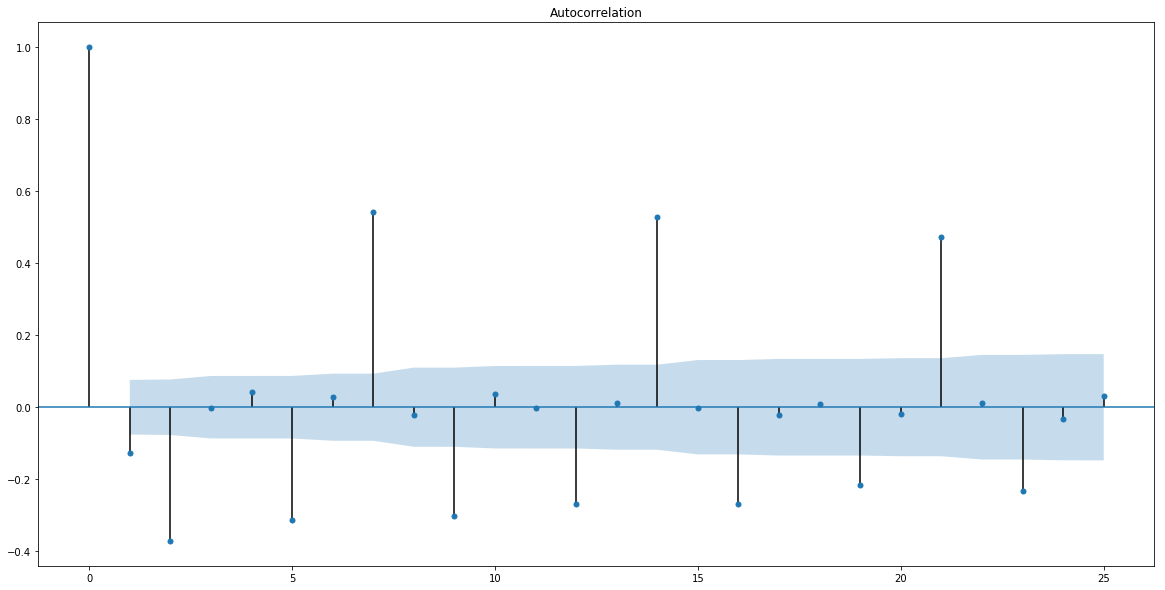

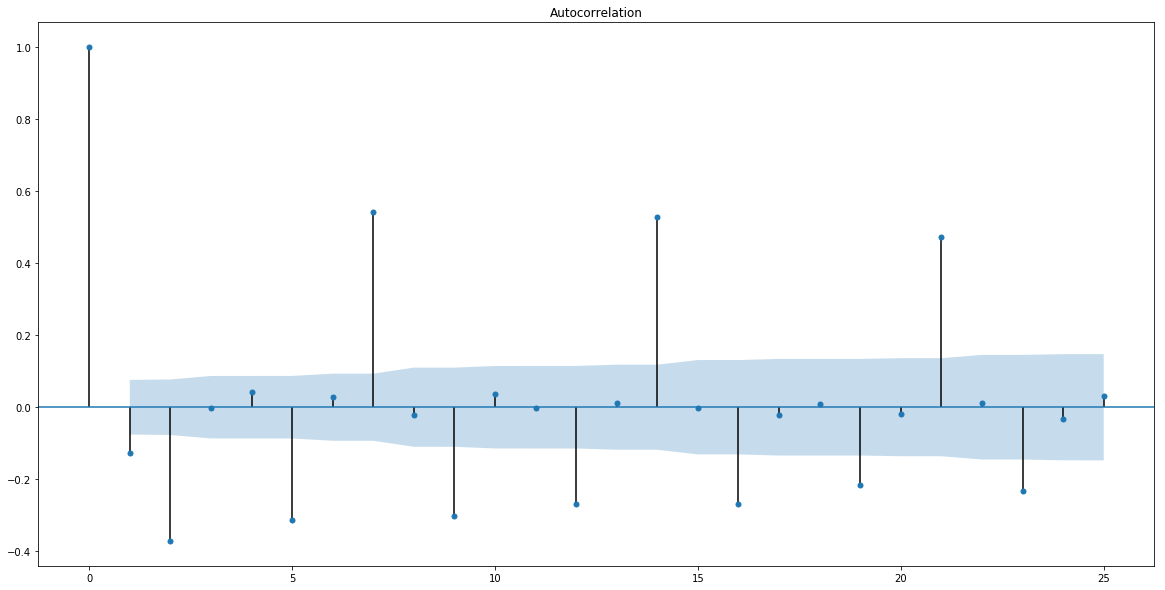

In [187]:
plot_acf(train_log_diff.dropna(),lags=25)

- q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

### PACF plot

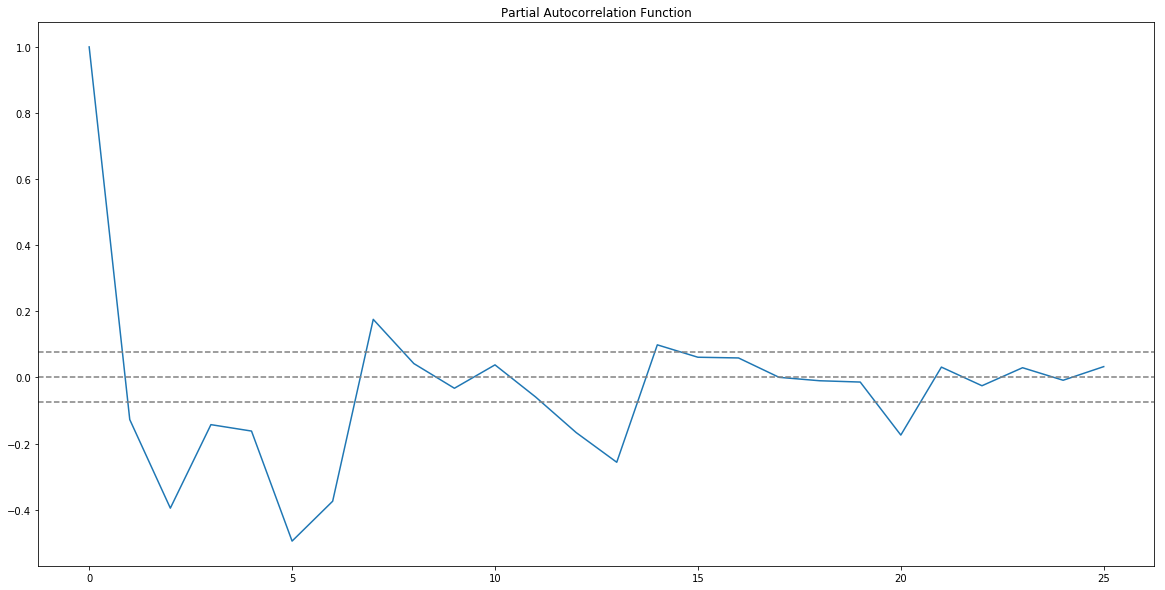

In [178]:
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

In [188]:
from statsmodels.graphics.tsaplots import plot_pacf

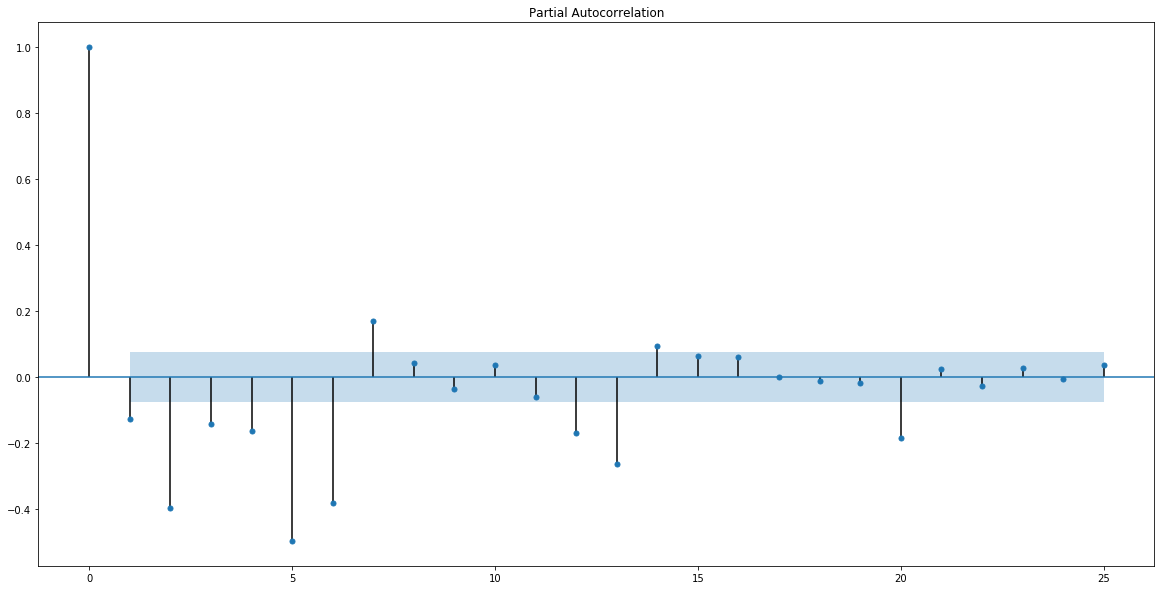

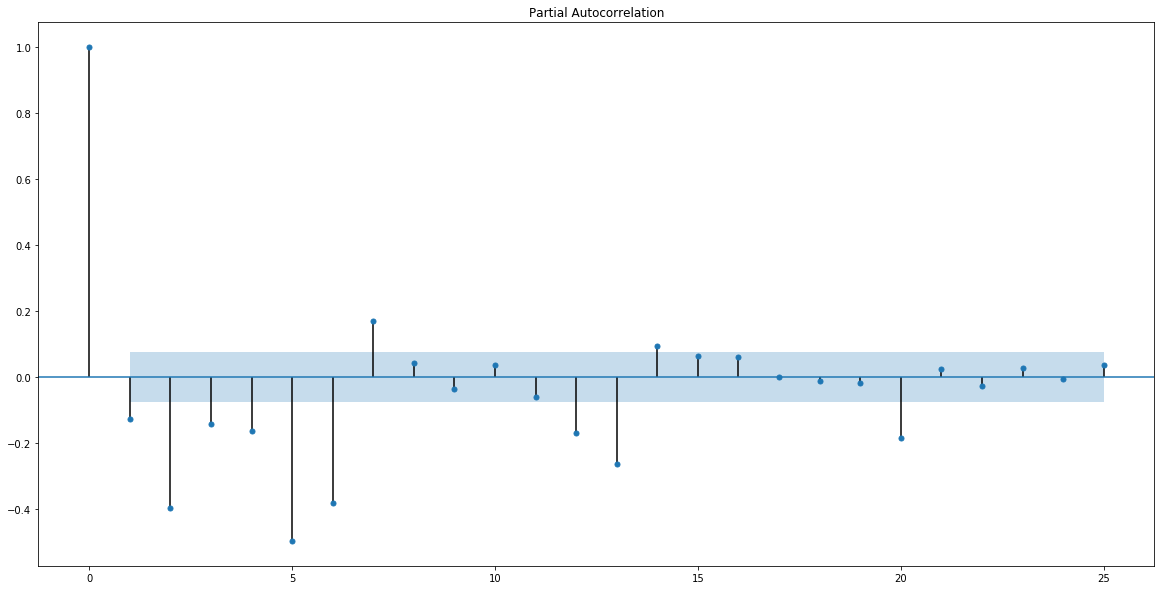

In [181]:
plot_pacf(train_log_diff.dropna(),lags=25)

- p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.

#### Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

### AR Model

- The autoregressive model specifies that the output variable depends linearly on its own previous values.

C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

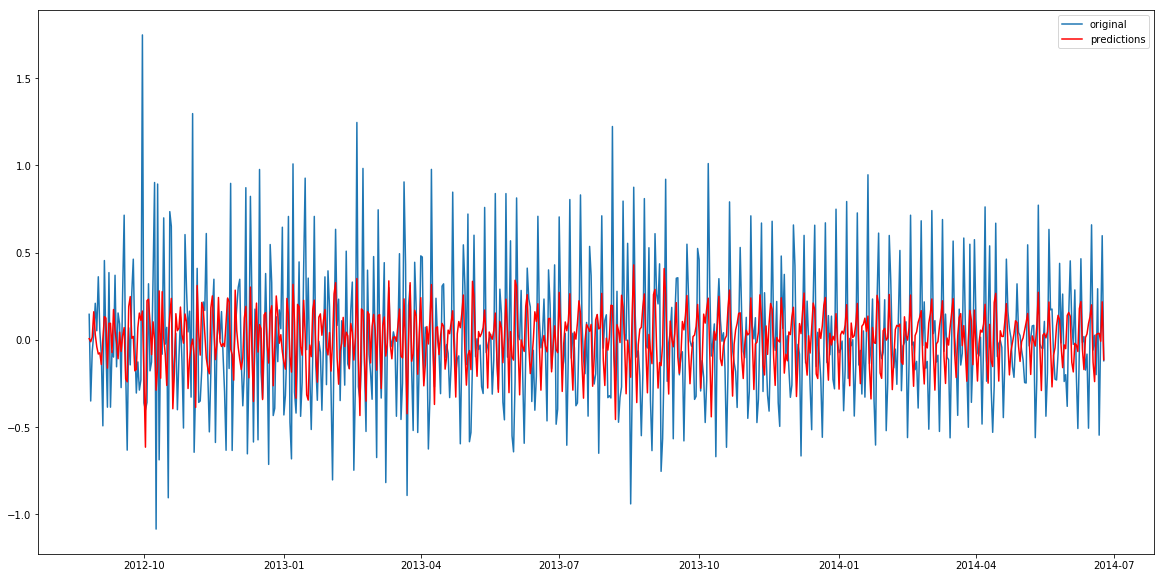

In [198]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0)) # here the q value is zero since it is just the AR model (p,d,q)
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

- Lets plot the validation curve for AR model.

- We have to change the scale of the model to the original scale.

- First step would be to store the predicted results as a separate series and observe it.

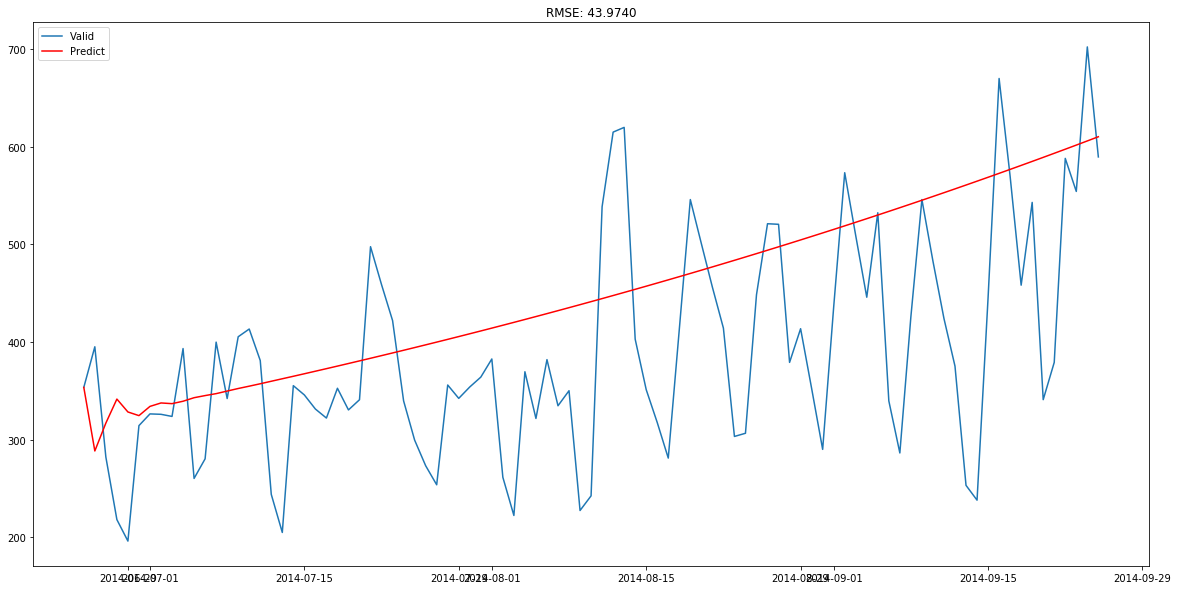

In [199]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
plt.plot(valid['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

- Here the red line shows the prediction for the validation set. Let’s build the MA model now.

### MA model 

- The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

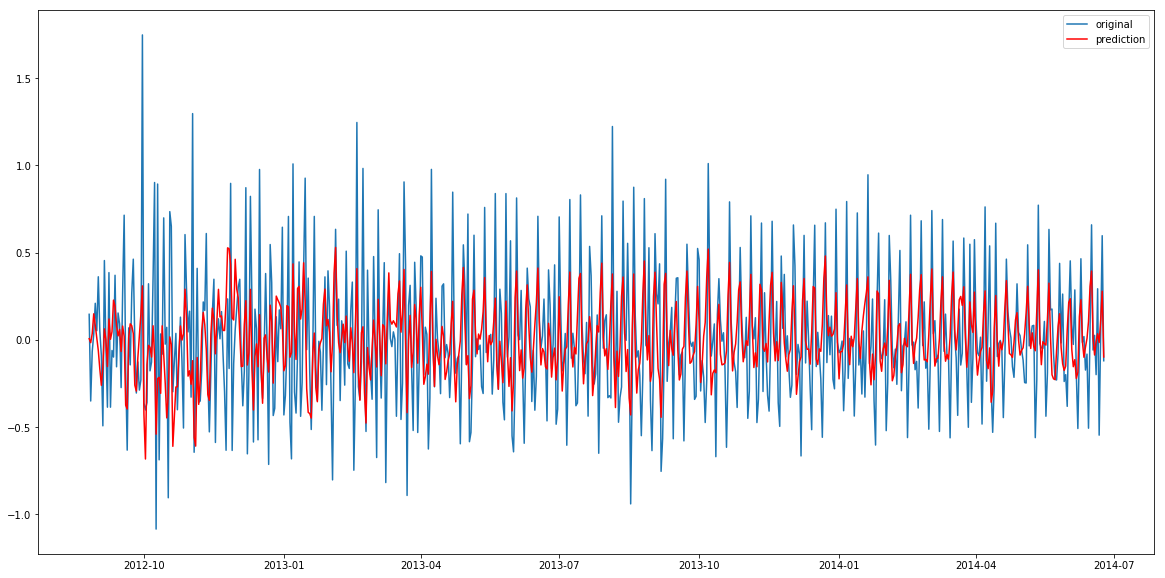

In [200]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model
results_MA = model.fit(disp=-1) 
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

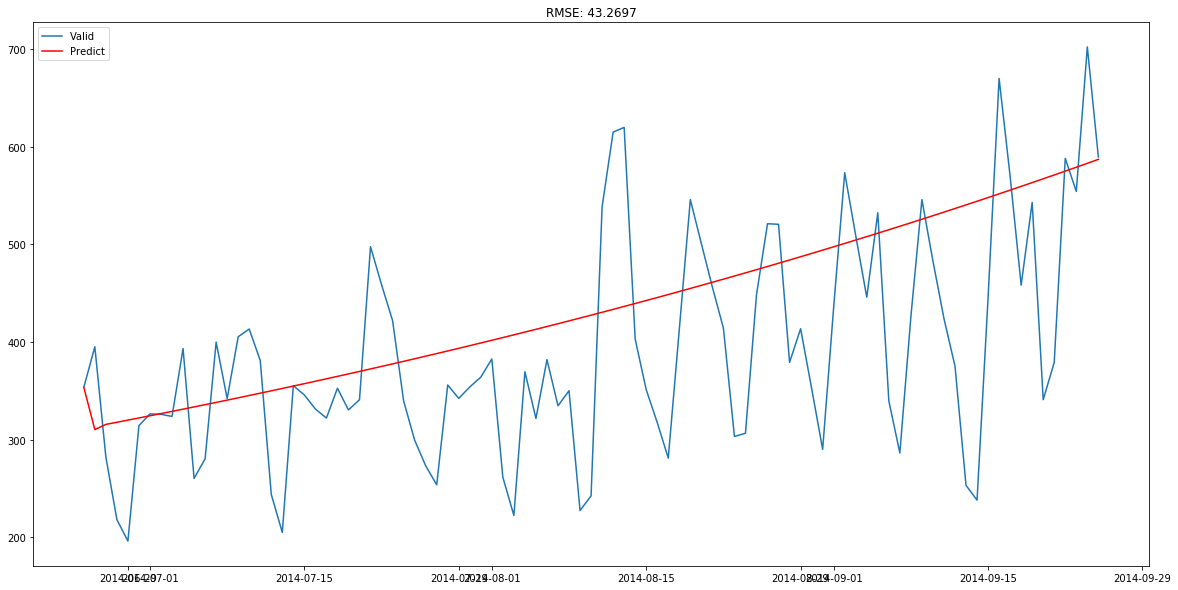

In [201]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)
plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()

- Now let’s combine these two models.
### Combined model

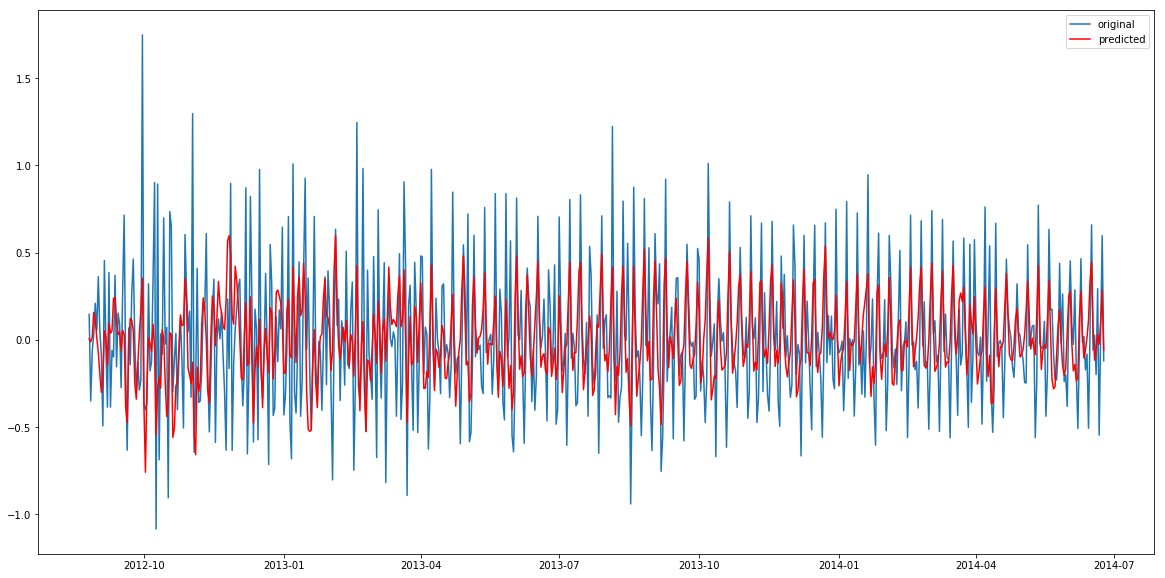

In [203]:
model = ARIMA(Train_log, order=(2, 1, 2))  ## both p and q values are there
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

- Let’s define a function which can be used to change the scale of the model to the original scale.

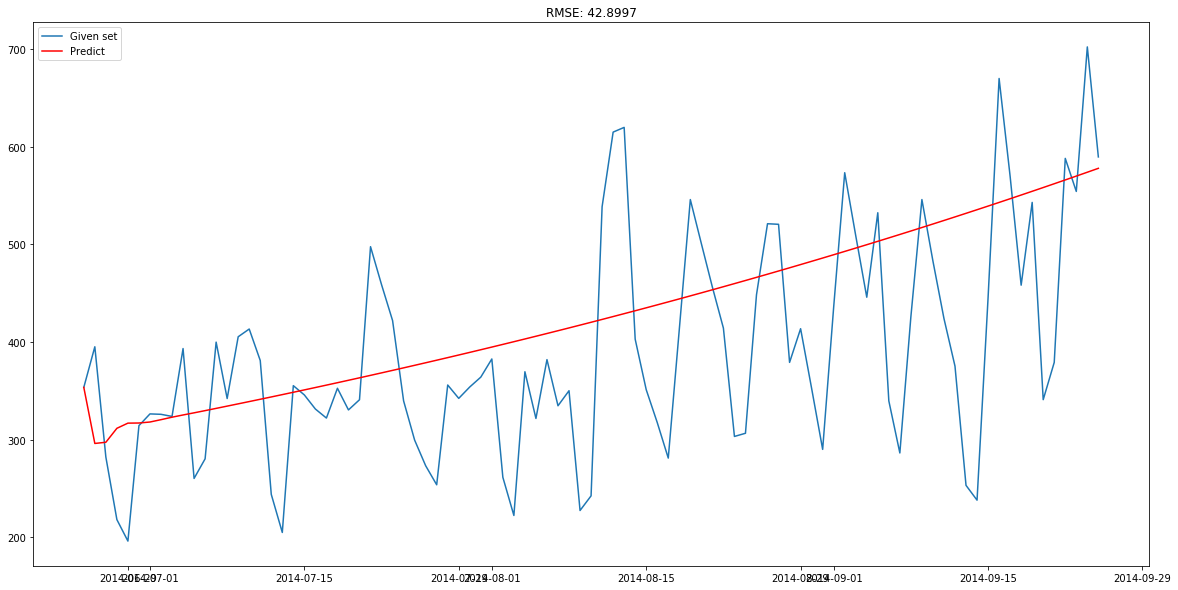

In [210]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()
    
##Let’s predict the values for validation set.

ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)

# Using Auto-Arima model

In [213]:
import pmdarima as pm


ModuleNotFoundError: No module named 'pmdarima'

In [211]:
model=auto_arima(Train_log,trace=True,error_action='ignore',suppress_warnings=True,start_P=0,max_p=10,start_Q=0,max_q=10,
                 seasonal=True,D=1,max_D=10)
model.fit(Train_log)

NameError: name 'auto_arima' is not defined

### 7) SARIMAX model on daily time series

- SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


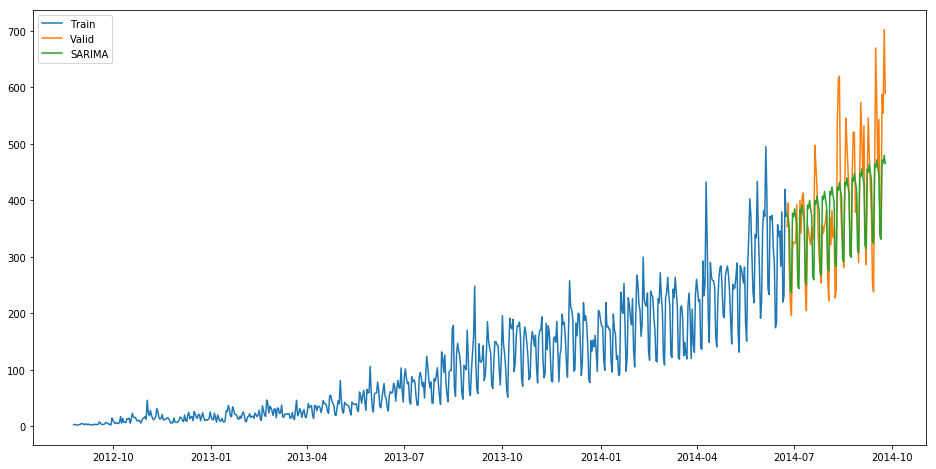

In [212]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

- Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.

- Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

- In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.


- Let’s check the rmse value for the validation part.

In [165]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print(rms)

70.01305241719037


#### Now we will forecast the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.

In [166]:
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)


C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


- Note that these are the daily predictions and we need hourly predictions. So, we will distribute this daily prediction into hourly counts. To do so, we will take the ratio of hourly distribution of passenger count from train data and then we will distribute the predictions in the same ratio.

In [167]:
test['prediction']=predict

# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24

#Let’s drop all variables other than ID and Count
prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

#Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')




In [171]:
rms = sqrt(mean_squared_error(prediction['Count'],prediction['prediction'])) 
print(rms)

172.83940147007348


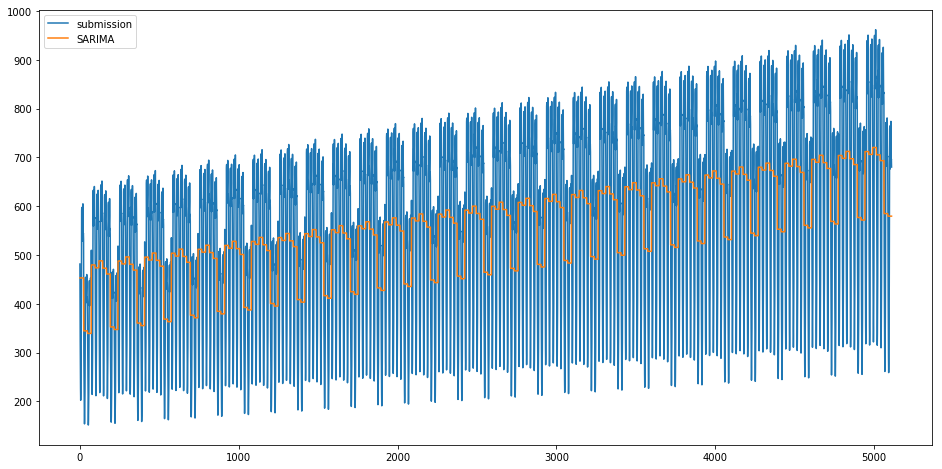

In [173]:
plt.figure(figsize=(16,8)) 
plt.plot( submission['Count'], label='submission') 

plt.plot(prediction['prediction'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()